In [1]:
%reload_ext autoreload
%autoreload 2
%pwd

'/home/dana/development/intradays/Intraday/notebooks'

In [2]:
import sys
sys.path.append('..')
from src.BotTrader import BotTrader
from src.NethFish import NethFish

In [3]:
# IMPORT local.seetings.json to Jupyter Notebook, so all secrets would be available

import os
import json

# Define the path to your local.settings.json file
settings_path = '/home/dana/development/intradays/local.settings.json'

try:
    with open(settings_path, 'r') as file:
        settings = json.load(file)

    # Extract the environment variables from the JSON structure
    # local.settings.json typically stores them under a "Values" key
    env_variables = settings.get('Values', {})  # Adjust key if necessary

    # Set the environment variables in the current Jupyter session
    for key, value in env_variables.items():
        os.environ[key] = str(value)

except Exception as e:
    print(f"Error loading environment variables: {e}")


In [4]:
import csv
import json

# Execute the cURL command and capture the output
import subprocess
import time
import urllib.parse
from abc import ABC, abstractmethod
from datetime import date, datetime, timedelta, timezone
from pathlib import Path
from typing import List, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from powerbot_client import (
    ApiClient,
    Configuration,
    ContractApi,
    MarketApi,
    OrderEntry,
    OrderModify,
    OrdersApi,
    SignalEntry,
    SignalsApi,
    SignalTimeSlice,
    TradesApi,
)
from pytz import FixedOffset  # For creating a fixed offset timezone
from sklearn.linear_model import LinearRegression

# Get trades for NL Fish

In [5]:
delivery_from = "2024-12-03T00:00:00Z"
delivery_to = "2024-12-31T09:00:00Z"

In [20]:
config = {
    "URL": os.environ['POWERBOT_HOST_URL_NORDPOOL'] ,
    "API_KEY_FROM": os.environ['POWERBOT_API_NL_FISH'] ,
    "API_KEY_TO": os.environ['POWERBOT_API_NL_FISH'] ,
    "DELIVERY_AREA": os.environ['NL_NORDPOOL_DELIVERY_AREA'] ,
    "DELIVERY_START_FROM": "2025-01-09T00:00:00Z",
    "DELIVERY_START_TO": "2025-01-15T08:00:00Z",
    "PORTFOLIO_ID_FROM": "P_NL5",
    "PORTFOLIO_ID_TO": "P_NL6",
    "settings": {"mode": "fast"}
}
nlfisk = NethFish(config)
nlfisk.get_trades()

In [21]:
nlfisk.get_weighted_average_prices()
nlfisk.get_weighted_average_minutes_to_delivery_start()

,trade_id,state,exchange,delivery_area,api_timestamp,exec_time,contract_id,contract_name,delivery_start,delivery_end,...,buy,sell,buy_portfolio_id,sell_portfolio_id,buy_txt,sell_txt,self_trade,weighted_mean_price,diff_hour,weighted_minutes_to_delivery_start
0,X586141480,ACTI,nordpool,10YNL----------L,2025-01-08 14:48:56.701000+00:00,2025-01-08 14:48:56.543000+00:00,NX_498337,PH-20250109-05,2025-01-09 03:00:00+00:00,2025-01-09 04:00:00+00:00,...,True,None,P_NL5,None,Opportunity SELL --SELL--Hour:3--Ref:94.64--Op...,None,False,62.510,12.184294,12.658396
1,X586399200,ACTI,nordpool,10YNL----------L,2025-01-08 21:34:49.642000+00:00,2025-01-08 21:34:49.579000+00:00,NX_498428,PH-20250109-16,2025-01-09 14:00:00+00:00,2025-01-09 15:00:00+00:00,...,True,None,P_NL5,None,Opportunity SELL --SELL--Hour:16--Ref:133.42--...,None,False,117.250,16.419561,13.729730
2,X586578347,ACTI,nordpool,10YNL----------L,2025-01-09 03:09:24.612000+00:00,2025-01-09 03:09:24.542000+00:00,NX_498456,PH-20250109-20,2025-01-09 18:00:00+00:00,2025-01-09 19:00:00+00:00,...,True,None,P_NL5,None,Regular BUY --BUY--Hour:18--Ref:101.66--Opp:11...,None,False,100.570,14.843183,13.343455
3,X587058554,ACTI,nordpool,10YNL----------L,2025-01-09 13:00:03.682000+00:00,2025-01-09 13:00:03.526000+00:00,NX_498489,PH-20250109-24,2025-01-09 22:00:00+00:00,2025-01-09 23:00:00+00:00,...,True,None,P_NL5,None,Opportunity SELL --SELL--Hour:0--Ref:90.01--Op...,None,False,76.350,8.999021,16.832844
4,X587197127,ACTI,nordpool,10YNL----------L,2025-01-09 16:14:37.219000+00:00,2025-01-09 16:14:37.168000+00:00,NX_498570,PH-20250110-11,2025-01-10 09:00:00+00:00,2025-01-10 10:00:00+00:00,...,True,None,P_NL5,None,Regular BUY --BUY--Hour:11--Ref:111.21--Opp:12...,None,False,106.550,16.756342,16.756342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,X590501217,ACTI,nordpool,10YNL----------L,2025-01-13 14:24:33.718000+00:00,2025-01-13 14:24:32.822000+00:00,NX_499321,PH-20250114-12,2025-01-14 10:00:00+00:00,2025-01-14 11:00:00+00:00,...,None,True,None,P_NL5,None,Opportunity BUY --BUY--Hour:12--Ref:94.0--Opp:...,False,109.900,19.590883,15.742988
103,X590757202,ACTI,nordpool,10YNL----------L,2025-01-13 21:02:22.180000+00:00,2025-01-13 21:02:22.114000+00:00,NX_499408,PH-20250114-23,2025-01-14 21:00:00+00:00,2025-01-14 22:00:00+00:00,...,None,True,None,P_NL5,None,Opportunity BUY --BUY--Hour:23--Ref:97.59--Opp...,False,110.430,23.960524,20.958793
104,X591285406,ACTI,nordpool,10YNL----------L,2025-01-14 13:04:16.810000+00:00,2025-01-14 13:04:16.558000+00:00,NX_499467,PH-20250115-07,2025-01-15 05:00:00+00:00,2025-01-15 06:00:00+00:00,...,None,True,None,P_NL5,None,Opportunity BUY --BUY--Hour:7--Ref:121.21--Opp...,False,158.905,15.928734,13.166931
105,X591315847,ACTI,nordpool,10YNL----------L,2025-01-14 13:44:26.707000+00:00,2025-01-14 13:44:26.587000+00:00,NX_499467,PH-20250115-07,2025-01-15 05:00:00+00:00,2025-01-15 06:00:00+00:00,...,None,True,None,P_NL5,None,Regular SELL --SELL--Hour:7--Ref:148.15--Opp:1...,False,158.905,15.259281,13.166931


In [22]:
data_vis = nlfisk.get_profit_loss()
# data_vis.to_csv('../outputs/trial_data.csv', index=False)

In [23]:
data_vis['contract_id'].unique()

array(['NX_498337', 'NX_498428', 'NX_498456', 'NX_498489', 'NX_498570',
       'NX_498612', 'NX_498630', 'NX_498604', 'NX_498676', 'NX_498669',
       'NX_498653', 'NX_498578', 'NX_498596', 'NX_498586', 'NX_498623',
       'NX_498660', 'NX_498725', 'NX_498825', 'NX_498733', 'NX_498832',
       'NX_498839', 'NX_498847', 'NX_498929', 'NX_498975', 'NX_498922',
       'NX_498967', 'NX_499163', 'NX_499138', 'NX_499090', 'NX_499154',
       'NX_499146', 'NX_499083', 'NX_499109', 'NX_499100', 'NX_499119',
       'NX_499177', 'NX_499170', 'NX_499240', 'NX_499321', 'NX_499289',
       'NX_499338', 'NX_499408', 'NX_499393', 'NX_499313', 'NX_499297',
       'NX_499305', 'NX_499345', 'NX_499329', 'NX_499375', 'NX_499415',
       'NX_499353', 'NX_499368', 'NX_499386', 'NX_499424', 'NX_499445',
       'NX_499467', 'NX_499459', 'NX_499431', 'NX_499452', 'NX_499482',
       'NX_498442', 'NX_498435', 'NX_498471', 'NX_498482', 'NX_498449',
       'NX_498531', 'NX_498524', 'NX_498538', 'NX_498517', 'NX_4

In [24]:
data_vis['hours_of_contract'] = data_vis['delivery_start'].dt.hour

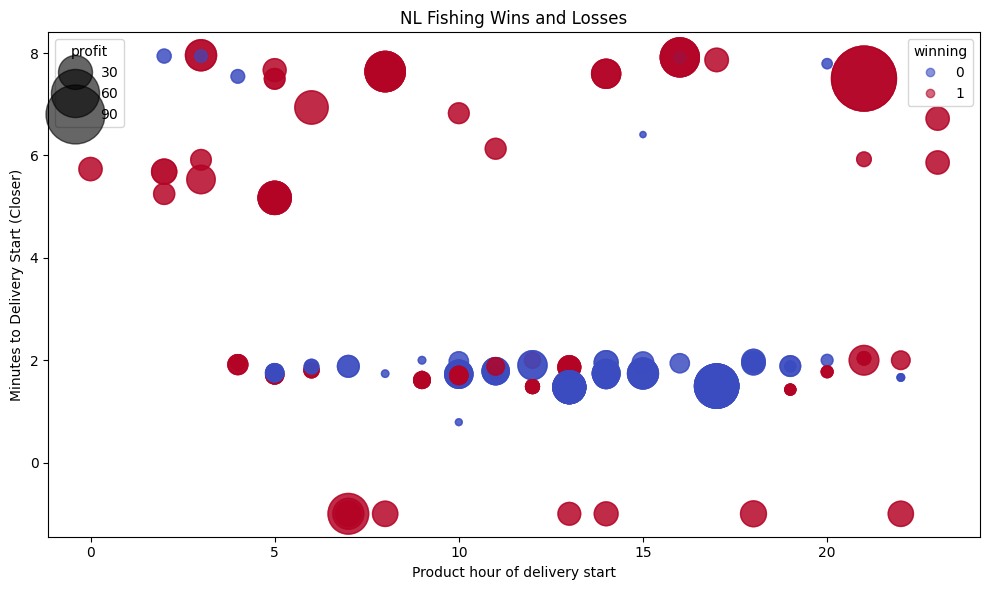

In [25]:
fig, ax = nlfisk.scatter_plot_for_hours(data_vis,
                             x_variable='hours_of_contract',
                             y_variable='weighted_minutes_to_delivery_start_closer',
                             boolean_variable='winning',
                             size_variable='profit',
                             title='NL Fishing Wins and Losses',
                             x_label_str='Product hour of delivery start',
                             y_label_str='Minutes to Delivery Start (Closer)',)
plt.show()
fig.savefig('../outputs/01_hours_to_delivery.jpeg', dpi=300)

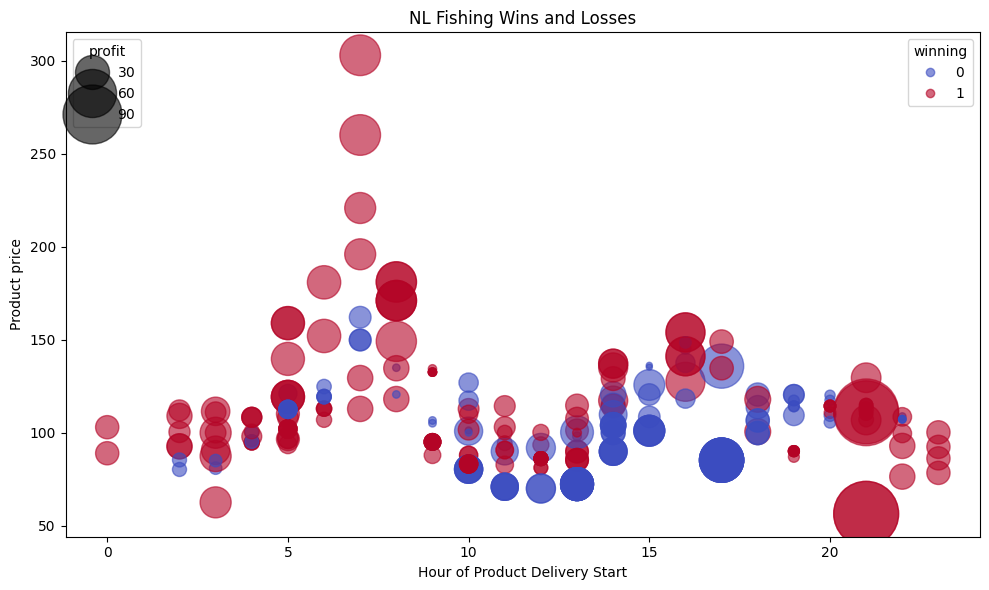

In [26]:
fig, ax = nlfisk.scatter_plot_for_hours(data_vis,
                             x_variable='hours_of_contract',
                             y_variable='weighted_mean_price',
                             boolean_variable='winning',
                             size_variable='profit',
                             title='NL Fishing Wins and Losses',
                             x_label_str='Hour of Product Delivery Start',
                             y_label_str='Product price',)
plt.show()
fig.savefig('../outputs/02_hours_to_price.jpeg', dpi=300)

In [27]:
unique_10_15 = data_vis.loc[(data_vis['hours_of_contract']>=10) & (data_vis['hours_of_contract'] <= 15),:]['exec_time'].unique()
data_vis.loc[~data_vis['exec_time'].isin(unique_10_15),:].profit.sum()

np.float64(1320.8930000000007)

In [28]:
unique_10_15 = data_vis.loc[(data_vis['hours_of_contract']>=10) & (data_vis['hours_of_contract'] <= 15),:]['exec_time'].unique()
data_vis.loc[data_vis['exec_time'].isin(unique_10_15),:].profit.sum()

np.float64(-513.0709999999999)

In [29]:
unique_10_15 = data_vis.loc[(data_vis['weighted_mean_price']>=90),:]['exec_time'].unique()
data_vis.loc[data_vis['exec_time'].isin(unique_10_15),:].profit.sum()

np.float64(1289.2390000000003)

In [30]:
unique_10_15 = data_vis.loc[(data_vis['weighted_mean_price']<90),:]['exec_time'].unique()
data_vis.loc[data_vis['exec_time'].isin(unique_10_15),:].profit.sum()

np.float64(-481.93399999999974)

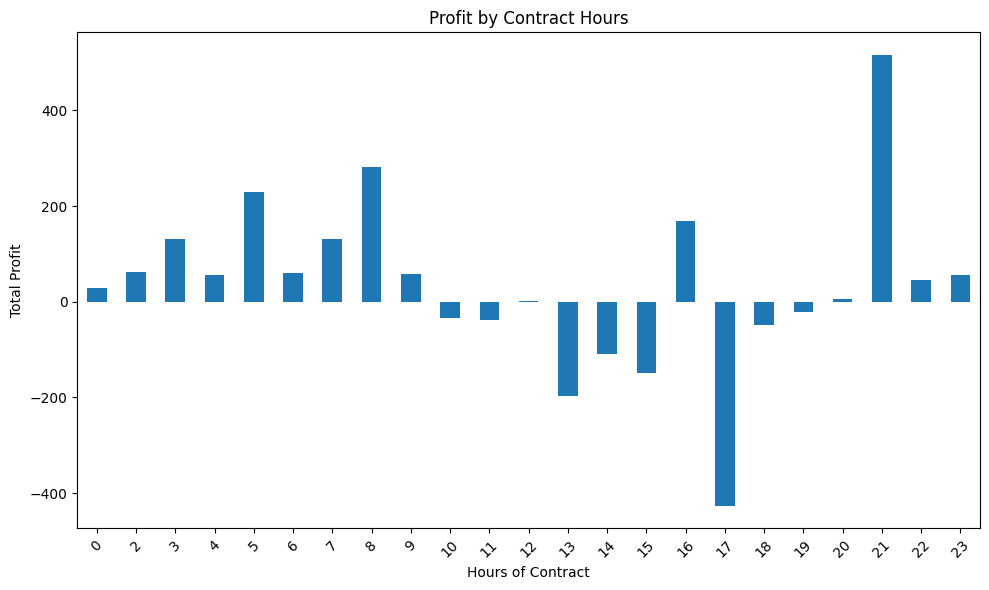

In [31]:
plot = data_vis.groupby('hours_of_contract').profit.sum().plot(kind='bar')

# Adjust the figure size if needed
plt.gcf().set_size_inches(10, 6)  # Makes the figure larger

# Add labels and title if desired
plt.xlabel('Hours of Contract')
plt.ylabel('Total Profit')
plt.title('Profit by Contract Hours')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Tight layout to prevent label cutoff
plt.tight_layout()

# Save the figure
plt.savefig('../outputs/03_hours_to_profit.jpeg',
            dpi=300,
            bbox_inches='tight')

# Show the plot (optional)
plt.show()


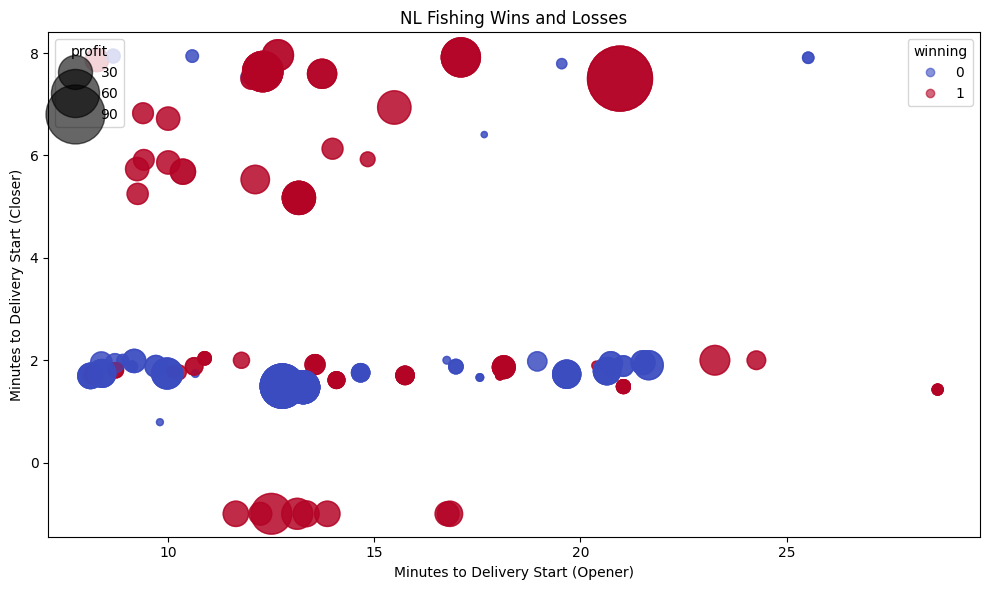

In [32]:
fig, ax = nlfisk.scatter_plot_for_hours(data_vis,
                             x_variable='weighted_minutes_to_delivery_start_opener',
                             y_variable='weighted_minutes_to_delivery_start_closer',
                             boolean_variable='winning',
                             size_variable='profit',
                             title='NL Fishing Wins and Losses',
                             x_label_str='Minutes to Delivery Start (Opener)',
                             y_label_str='Minutes to Delivery Start (Closer)',)
plt.show()
fig.savefig('../outputs/04_hours_to_hours.jpeg', dpi=300)

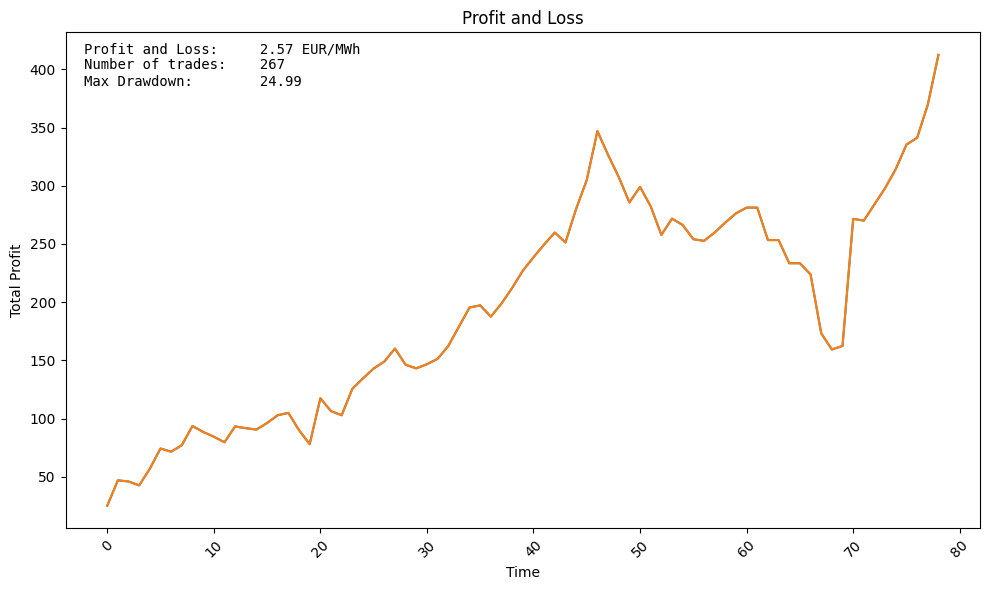

In [33]:
pnl_data = data_vis[['contract_id', 'pnl', 'delivery_start']].drop_duplicates().sort_values(by='delivery_start', ascending=True)
pnl_data.reset_index(drop=True, inplace=True)
pnl_data.pnl.plot()

plot = pnl_data.pnl.plot()

eur_mwh = round(pnl_data.pnl.iloc[-1] / nlfisk.trades.quantity.sum(),2)
number_of_trades = nlfisk.trades.trade_id.count()
max_drawdown = round(pnl_data.pnl.min(),2)


# Adjust the figure size if needed
plt.gcf().set_size_inches(10, 6)  # Makes the figure larger

# Add labels and title if desired
plt.xlabel('Time')
plt.ylabel('Total Profit')
plt.title(f"Profit and Loss") 

text_template = (
    "Profit and Loss:     %(profit).2f EUR/MWh\n"
    "Number of trades:    %(trades)d\n"
    "Max Drawdown:        %(drawdown).2f"
)
text_values = {
    'profit': eur_mwh,
    'trades': number_of_trades,
    'drawdown': max_drawdown
}
plt.text(0.02, 0.98,
         text_template % text_values,
         transform=plt.gca().transAxes,
         verticalalignment='top',
         horizontalalignment='left',
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=3),
         family='monospace')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Tight layout to prevent label cutoff
plt.tight_layout()

# Save the figure
plt.savefig('../outputs/04_hours_to_profit.jpeg',
            dpi=300,
            bbox_inches='tight')

# Show the plot (optional)
plt.show()

In [34]:
nlfisk.trades.trade_id.count()

np.int64(267)

In [35]:
pnl_data.pnl.iloc[-1] / nlfisk.trades.quantity.sum()


np.float64(1.2331922398589075)

In [579]:
nlfisk.trades[nlfisk.trades['delivery_start'] == '2025-01-12 08:00:00+00:00'][['delivery_start', 'exec_time', 'price', 'quantity', 'buy']]

,delivery_start,exec_time,price,quantity,buy
27,2025-01-12 08:00:00+00:00,2025-01-11 14:56:55.703000+00:00,134.64,1.0,None
35,2025-01-12 08:00:00+00:00,2025-01-11 21:20:13.230000+00:00,118.07,1.0,True


In [562]:
data_vis[data_vis['delivery_start'] == '2025-01-12 08:00:00+00:00'][['delivery_start', 'exec_time', 'price', 'quantity', 'buy', 'profit','weighted_minutes_to_delivery_start_closer']]

,delivery_start,exec_time,price,quantity,buy,profit,weighted_minutes_to_delivery_start_closer
20,2025-01-12 08:00:00+00:00,2025-01-11 21:20:13.230000+00:00,118.07,1.0,True,16.57,NaN
55,2025-01-12 08:00:00+00:00,2025-01-11 14:56:55.703000+00:00,134.64,1.0,None,16.57,NaN


In [553]:
data_vis[data_vis['weighted_minutes_to_delivery_start_closer'].isna()]
#data_vis.describe()

,trade_id,state,exchange,delivery_area,api_timestamp,exec_time,contract_id,contract_name,delivery_start,delivery_end,...,weighted_minutes_to_delivery_start,quantity_bought,price_bought,quantity_sold,price_sold,profit,pnl,winning,weighted_minutes_to_delivery_start_opener,weighted_minutes_to_delivery_start_closer
20,X589061080,ACTI,nordpool,10YNL----------L,2025-01-11 21:20:22.522000+00:00,2025-01-11 21:20:13.230000+00:00,NX_498929,PH-20250112-10,2025-01-12 08:00:00+00:00,2025-01-12 09:00:00+00:00,...,13.857093,1.0,118.07,1.0,134.64,16.57,101.831,True,13.857093,NaN
21,X589068390,ACTI,nordpool,10YNL----------L,2025-01-11 21:27:28.633000+00:00,2025-01-11 21:27:28.534000+00:00,NX_498975,PH-20250112-16,2025-01-12 14:00:00+00:00,2025-01-12 15:00:00+00:00,...,16.762281,1.0,114.32,1.0,129.07,14.75,133.391,True,16.762281,NaN
22,X589071276,ACTI,nordpool,10YNL----------L,2025-01-11 21:30:15.715000+00:00,2025-01-11 21:30:14.612000+00:00,NX_498922,PH-20250112-09,2025-01-12 07:00:00+00:00,2025-01-12 08:00:00+00:00,...,11.637634,1.0,112.76,1.0,129.36,16.60,85.261,True,11.637634,NaN
23,X589257016,ACTI,nordpool,10YNL----------L,2025-01-12 04:44:29.041000+00:00,2025-01-12 04:44:28.980000+00:00,NX_498967,PH-20250112-15,2025-01-12 13:00:00+00:00,2025-01-12 14:00:00+00:00,...,12.232646,1.0,101.23,1.0,114.62,13.39,118.641,True,12.232646,NaN
30,X589613493,ACTI,nordpool,10YNL----------L,2025-01-12 14:28:39.245000+00:00,2025-01-12 14:28:39.192000+00:00,NX_499109,PH-20250113-09,2025-01-13 07:00:00+00:00,2025-01-13 08:00:00+00:00,...,13.127061,1.0,195.92,1.0,220.80,24.88,211.405,True,13.127061,NaN
55,X588862915,ACTI,nordpool,10YNL----------L,2025-01-11 14:56:55.737000+00:00,2025-01-11 14:56:55.703000+00:00,NX_498929,PH-20250112-10,2025-01-12 08:00:00+00:00,2025-01-12 09:00:00+00:00,...,13.857093,1.0,118.07,1.0,134.64,16.57,101.831,True,13.857093,NaN
59,X588945791,ACTI,nordpool,10YNL----------L,2025-01-11 17:13:14.464000+00:00,2025-01-11 17:13:14.421000+00:00,NX_498922,PH-20250112-09,2025-01-12 07:00:00+00:00,2025-01-12 08:00:00+00:00,...,11.637634,1.0,112.76,1.0,129.36,16.60,85.261,True,11.637634,NaN
60,X589046208,ACTI,nordpool,10YNL----------L,2025-01-11 20:47:36.037000+00:00,2025-01-11 20:47:35.971000+00:00,NX_498967,PH-20250112-15,2025-01-12 13:00:00+00:00,2025-01-12 14:00:00+00:00,...,12.232646,1.0,101.23,1.0,114.62,13.39,118.641,True,12.232646,NaN
62,X589051631,ACTI,nordpool,10YNL----------L,2025-01-11 21:01:03.186000+00:00,2025-01-11 21:01:03.043000+00:00,NX_498975,PH-20250112-16,2025-01-12 14:00:00+00:00,2025-01-12 15:00:00+00:00,...,16.762281,1.0,114.32,1.0,129.07,14.75,133.391,True,16.762281,NaN
66,X589821950,ACTI,nordpool,10YNL----------L,2025-01-12 21:16:06.009000+00:00,2025-01-12 21:16:05.970000+00:00,NX_499109,PH-20250113-09,2025-01-13 07:00:00+00:00,2025-01-13 08:00:00+00:00,...,13.127061,1.0,195.92,1.0,220.80,24.88,211.405,True,13.127061,NaN


In [197]:
data_closer = nlfisk.trades_from_closer
data_closer.shape

(95, 19)

In [ ]:
target_date = pd.Timestamp('2025-01-14T00:00:00Z', tz='UTC')
filtered_df2 = data_closer.loc[data_closer['delivery_start'] > target_date]
filtered_df2.shape

In [207]:
data_opener = nlfisk.trades_from_opener
from_hour_date = pd.Timestamp('2025-01-13T8:00:00Z', tz='UTC')
to_hour_date = pd.Timestamp('2025-01-13T9:00:00Z', tz='UTC')
opener_for_the_hour = data_opener.loc[(data_opener['delivery_start'] >= from_hour_date) & (data_opener['delivery_start'] < to_hour_date)]
opener_for_the_hour.head()

,trade_id,state,exchange,delivery_area,api_timestamp,exec_time,contract_id,contract_name,delivery_start,delivery_end,...,quantity,buy,sell,buy_portfolio_id,sell_portfolio_id,buy_txt,sell_txt,self_trade,diff_hour,diff_hour_floor
49,X589622248,ACTI,nordpool,10YNL----------L,2025-01-12 14:43:16.563000+00:00,2025-01-12 14:43:16.504000+00:00,NX_499119,PH-20250113-10,2025-01-13 08:00:00+00:00,2025-01-13 09:00:00+00:00,...,1.0,True,None,P_NL5,None,Regular BUY --BUY--Hour:10--Ref:153.9--Opp:171.0,None,False,17.278749,17
44,X589821976,ACTI,nordpool,10YNL----------L,2025-01-12 21:16:15.898000+00:00,2025-01-12 21:16:15.854000+00:00,NX_499119,PH-20250113-10,2025-01-13 08:00:00+00:00,2025-01-13 09:00:00+00:00,...,1.0,None,True,None,P_NL5,None,Opportunity BUY --BUY--Hour:10--Ref:153.9--Opp...,False,10.728929,10
42,X589888114,ACTI,nordpool,10YNL----------L,2025-01-12 23:08:12.787000+00:00,2025-01-12 23:08:12.733000+00:00,NX_499119,PH-20250113-10,2025-01-13 08:00:00+00:00,2025-01-13 09:00:00+00:00,...,1.0,None,True,None,P_NL5,None,Regular SELL --SELL--Hour:10--Ref:188.1--Opp:1...,False,8.863130,8


In [204]:
data_opener.loc[:,'diff_hour'] = (data_opener.loc[:,'delivery_start'] - data_opener.loc[:,'exec_time']).dt.total_seconds() / 60  / 60
data_opener.loc[:, 'diff_hour_floor'] = data_opener['diff_hour'].apply(np.floor).apply(int)

In [200]:
# time before
# compute the minutes between delivery_start - exec_time
data_closer.loc[:,'diff_hour'] = (data_closer.loc[:,'delivery_start'] - data_closer.loc[:,'exec_time']).dt.total_seconds() / 60  / 60
data_closer.loc[:, 'diff_hour_floor'] = data_closer['diff_hour'].apply(np.floor).apply(int)

<Axes: >

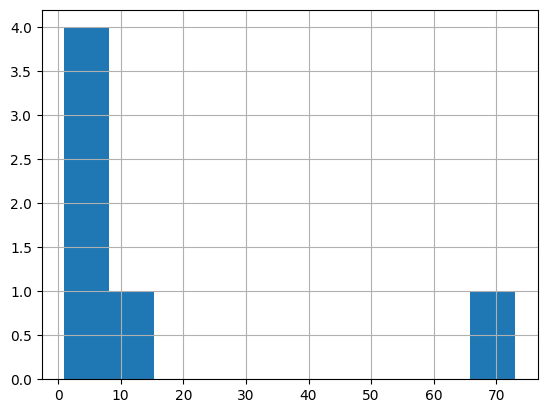

In [372]:
data_closer['diff_hour_floor'].value_counts().hist()

<Axes: >

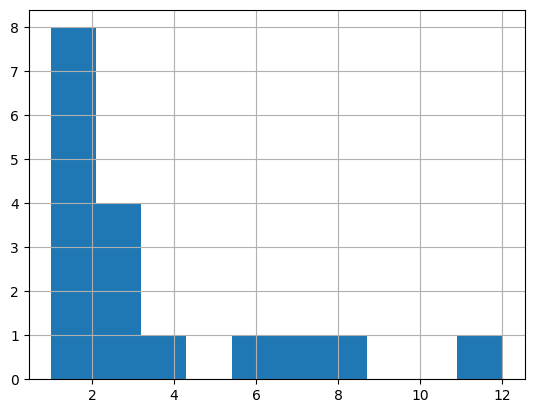

In [370]:
data_opener['diff_hour_floor'].value_counts().hist()

In [210]:
data_opener[data_opener['contract_id'] == 'NX_499119']

,trade_id,state,exchange,delivery_area,api_timestamp,exec_time,contract_id,contract_name,delivery_start,delivery_end,...,quantity,buy,sell,buy_portfolio_id,sell_portfolio_id,buy_txt,sell_txt,self_trade,diff_hour,diff_hour_floor
49,X589622248,ACTI,nordpool,10YNL----------L,2025-01-12 14:43:16.563000+00:00,2025-01-12 14:43:16.504000+00:00,NX_499119,PH-20250113-10,2025-01-13 08:00:00+00:00,2025-01-13 09:00:00+00:00,...,1.0,True,None,P_NL5,None,Regular BUY --BUY--Hour:10--Ref:153.9--Opp:171.0,None,False,17.278749,17
44,X589821976,ACTI,nordpool,10YNL----------L,2025-01-12 21:16:15.898000+00:00,2025-01-12 21:16:15.854000+00:00,NX_499119,PH-20250113-10,2025-01-13 08:00:00+00:00,2025-01-13 09:00:00+00:00,...,1.0,None,True,None,P_NL5,None,Opportunity BUY --BUY--Hour:10--Ref:153.9--Opp...,False,10.728929,10
42,X589888114,ACTI,nordpool,10YNL----------L,2025-01-12 23:08:12.787000+00:00,2025-01-12 23:08:12.733000+00:00,NX_499119,PH-20250113-10,2025-01-13 08:00:00+00:00,2025-01-13 09:00:00+00:00,...,1.0,None,True,None,P_NL5,None,Regular SELL --SELL--Hour:10--Ref:188.1--Opp:1...,False,8.863130,8


In [538]:
data_opener[data_opener['contract_id'] == 'NX_499119']
data_closer[data_closer['contract_id'] == 'NI_606275']

,trade_id,state,exchange,delivery_area,api_timestamp,exec_time,contract_id,contract_name,delivery_start,delivery_end,...,buy,sell,buy_portfolio_id,sell_portfolio_id,buy_txt,sell_txt,self_trade,diff_hour,diff_hour_floor,diff_minutes


* 2 MW sold, 1 MW bought - this was profitable? -> check performance of position opener against our own trades
    * selling prices buying prices how to match them meaningfully?

* average hour weighted by volume for position opener and closer and then see where the profit comes

In [ ]:
# Average sell and buy prices per contract_id

In [220]:
data_closer.columns

Index(['trade_id', 'state', 'exchange', 'delivery_area', 'api_timestamp',
       'exec_time', 'contract_id', 'contract_name', 'delivery_start',
       'delivery_end', 'price', 'quantity', 'buy', 'sell', 'buy_portfolio_id',
       'sell_portfolio_id', 'buy_txt', 'sell_txt', 'self_trade', 'diff_hour',
       'diff_hour_floor'],
      dtype='object')

In [287]:
data_opener.groupby(['contract_id', 'buy'])['price'].mean()
tablebuy = data_opener.groupby(['contract_id', 'buy'])['quantity'].sum()

# data_closer[(data_closer['contract_id'] == 'NX_499119') & (data_closer['buy'] == True)]

In [244]:
tablebuy = pd.DataFrame(tablebuy)
tablebuy

,,quantity
contract_id,buy,
NX_498570,True,1.0
NX_498578,True,1.0
NX_498586,True,1.0
NX_498596,True,1.0
NX_498604,True,1.0
NX_498612,True,1.0
NX_498623,True,1.0
NX_498630,True,1.0
NX_498653,True,1.0


In [286]:
data_opener.groupby(['contract_id', 'sell'])['price'].mean()
tablesell = data_opener.groupby(['contract_id', 'sell'])['quantity'].sum()
tablesell = pd.DataFrame(tablesell)
tablesell

,,quantity
contract_id,sell,
NX_498517,True,1.0
NX_498524,True,1.0
NX_498531,True,1.0
NX_498538,True,1.0
NX_498630,True,2.0
NX_498763,True,1.0
NX_498905,True,1.0
NX_498922,True,1.0
NX_498929,True,1.0


In [292]:
opener_performance = pd.merge(tablesell, tablebuy, on='contract_id', how='outer')
equal_openers = opener_performance[opener_performance['quantity_x'] == opener_performance['quantity_y']]
equal_openers = equal_openers.reset_index().rename(columns={'index': 'contract_id'})
opener_only = data_opener[data_opener['contract_id'].isin(equal_openers['contract_id'])]
opener_only.shape


(10, 21)

In [289]:
data_opener[data_opener['contract_id'] == 'NX_498929']

,trade_id,state,exchange,delivery_area,api_timestamp,exec_time,contract_id,contract_name,delivery_start,delivery_end,...,quantity,buy,sell,buy_portfolio_id,sell_portfolio_id,buy_txt,sell_txt,self_trade,diff_hour,diff_hour_floor
38,X588862915,ACTI,nordpool,10YNL----------L,2025-01-11 14:56:55.737000+00:00,2025-01-11 14:56:55.703000+00:00,NX_498929,PH-20250112-10,2025-01-12 08:00:00+00:00,2025-01-12 09:00:00+00:00,...,1.0,None,True,None,P_NL5,None,Regular SELL --SELL--Hour:10--Ref:132.08--Opp:...,False,17.051194,17
30,X589061080,ACTI,nordpool,10YNL----------L,2025-01-11 21:20:22.522000+00:00,2025-01-11 21:20:13.230000+00:00,NX_498929,PH-20250112-10,2025-01-12 08:00:00+00:00,2025-01-12 09:00:00+00:00,...,1.0,True,None,P_NL5,None,Opportunity SELL --SELL--Hour:10--Ref:132.08--...,None,False,10.662992,10


<Axes: xlabel='diff_hour_floor', ylabel='price_diff'>

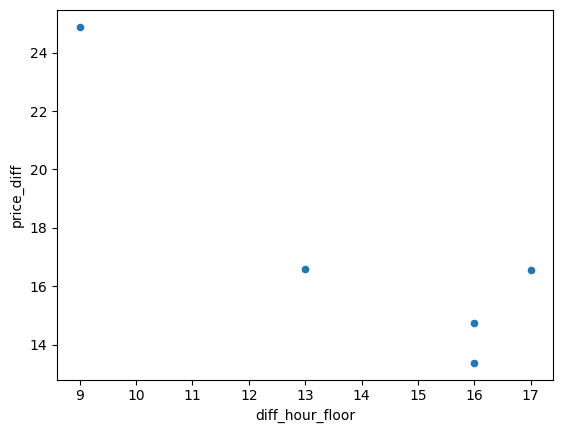

In [303]:
small_opener = opener_only.sort_values(by=['contract_id','buy', 'delivery_start'])[['contract_id','buy','delivery_start', 'price', 'diff_hour_floor']]
small_opener['price_diff'] = small_opener.groupby('contract_id')['price'].diff()
small_opener.plot(x='diff_hour_floor', y='price_diff', kind='scatter')

In [365]:
data_opener.loc[:,'diff_minutes'] = (data_opener.loc[:,'delivery_start'] - data_opener.loc[:,'exec_time']).dt.total_seconds() / 60

data_closer.loc[:,'diff_minutes'] = (data_closer.loc[:,'delivery_start'] - data_closer.loc[:,'exec_time']).dt.total_seconds() / 60

opener_grouped_weighted_mean = (
    data_opener.groupby('contract_id')
    .apply(lambda x: np.average(x['diff_minutes'], weights=x['quantity']), include_groups=False)
)
closer_grouped_weighted_mean = (
    data_closer.groupby('contract_id')
    .apply(lambda x: np.average(x['diff_minutes'], weights=x['quantity']), include_groups=False)
)
avg_hours_opener = opener_grouped_weighted_mean.reset_index().rename(columns={0: 'avg_hours_opener'})
avg_hours_closer = closer_grouped_weighted_mean.reset_index().rename(columns={0: 'avg_hours_closer'})
avg_hours = pd.merge(avg_hours_opener, avg_hours_closer, on='contract_id', how='outer')
dates_of_trades = nlfisk.trades[nlfisk.trades['contract_id'].isin(avg_hours['contract_id'])][['contract_id', 'delivery_start']]
contracts_to_analyze = nlfisk.trades[nlfisk.trades['contract_id'].isin(avg_hours['contract_id'])]

# get dates of trades
dates_of_trades = nlfisk.trades[nlfisk.trades['contract_id'].isin(avg_hours['contract_id'])][['contract_id', 'delivery_start']]
dates_of_trades['delivery_start_date'] = dates_of_trades['delivery_start'].dt.day
dates_of_trades = dates_of_trades[['contract_id', 'delivery_start_date']]

# get sum of trades
bought_amount = contracts_to_analyze.groupby(['contract_id', 'buy'])['quantity'].sum()
sold_amount = contracts_to_analyze.groupby(['contract_id', 'sell'])['quantity'].sum()
buy_price_avg = contracts_to_analyze.groupby(['contract_id', 'buy'])['price'].mean()
sell_price_avg = contracts_to_analyze.groupby(['contract_id', 'sell'])['price'].mean()

# compute profit and loss bought amount times buy price - sold amount times sell price
bought_amount = pd.DataFrame(bought_amount)
sold_amount = pd.DataFrame(sold_amount)
buy_price_avg = pd.DataFrame(buy_price_avg)
sell_price_avg = pd.DataFrame(sell_price_avg)
buy_sell = pd.merge(bought_amount, sold_amount, on='contract_id', how='outer')
buy_sell.rename(columns={'quantity_x': 'quantity_bought', 'quantity_y': 'quantity_sold'}, inplace=True)
buy_sell = pd.merge(buy_sell, buy_price_avg, on='contract_id', how='outer')
buy_sell.rename(columns={'price': 'price_bought'}, inplace=True)
buy_sell = pd.merge(buy_sell, sell_price_avg, on='contract_id', how='outer')
buy_sell.rename(columns={'price': 'price_sold'}, inplace=True)
buy_sell = buy_sell.fillna(0)
buy_sell['profit'] = buy_sell['quantity_sold'] * buy_sell['price_sold'] - buy_sell['quantity_bought'] * buy_sell['price_bought']
buy_sell['pnl'] = buy_sell['profit'].cumsum()

with_hours = pd.merge(buy_sell, avg_hours, on='contract_id', how='left')
with_hours = pd.merge(with_hours, dates_of_trades, on='contract_id', how='left')



<Axes: xlabel='delivery_start_date', ylabel='profit'>

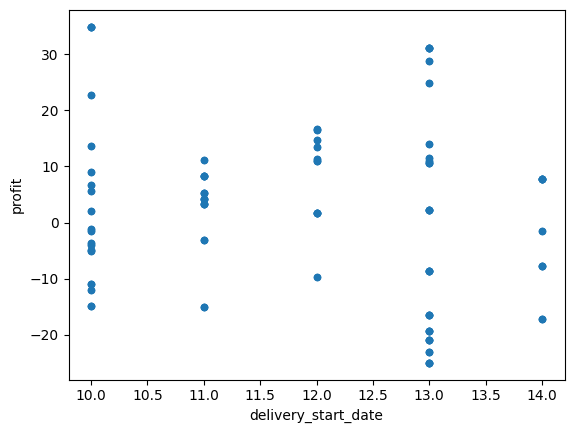

In [356]:
with_hours.plot(x='delivery_start_date', y='profit', kind='scatter')

 # with_hours

<Axes: xlabel='avg_hours_opener', ylabel='profit'>

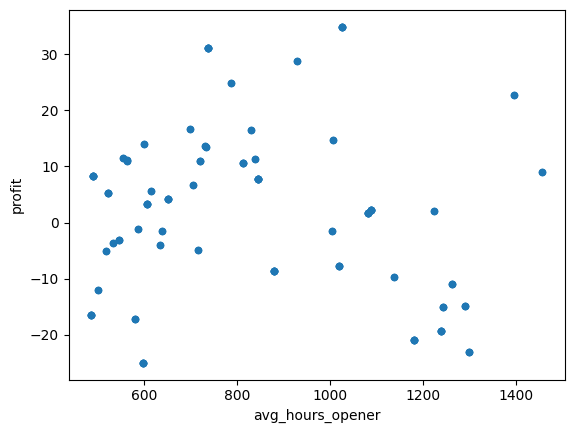

In [361]:
with_hours.plot(x='avg_hours_opener', y='profit', kind='scatter')

<Axes: >

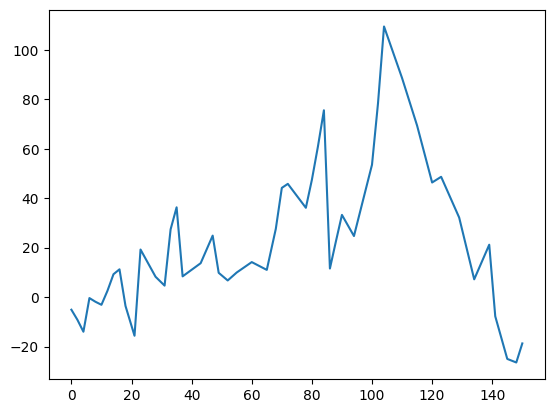

In [369]:
#with_hours.groupby('delivery_start_date')['profit'].cumsum().plot()
with_hours.drop_duplicates().groupby('delivery_start_date')['profit'].cumsum().plot()